#Importing necessary packages and data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding visualization
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

In [ ]:
!pip install tensorflow==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.7 MB 16 kB/s 
     |████████████████████████████████| 14.8 MB 35.4 MB/s 
     |████████████████████████████████| 462 kB 51.1 MB/s 
     |████████████████████████████████| 2.9 MB 40.2 MB/s 
     |████████████████████████████████| 132 kB 41.8 MB/s 
     |████████████████████████████████| 3.8 MB 43.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=3240862348f80c6afdd20ccc092c7d18f1862336aa82c940f2035c38585d7279
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: n

In [ ]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
data = pd.read_csv(train_url)
data.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

## Constructing a function to return a data data tensor object

We will create a function called make_dataset that will remove stopwords and return a tf.data.Dataset with 2 inputs and one output.

In [ ]:
def make_dataset(data):

  pat = r'\b(?:{})\b'.format('|'.join(stopwords))
  data['title'] = data['title'].str.replace(pat, '')
  data['title'] = data['title'].str.replace(r'\s+', ' ')
  data['text'] = data['text'].str.replace(pat, '')
  data['text'] = data['text'].str.replace(r'\s+', ' ')

  data = tf.data.Dataset.from_tensor_slices(
    ( # dictionary for input data/features
     # two inputs: title and text
        { "title": data[["title"]],
     "text": data[["text"]]
      },
    # dictionary for output data/labels
    # one ouput: fake
      { "fake": data[["fake"]]

      }
    )
  )
  data = data.batch(100)
  return(data)

#batch our data to make training faster; train on chunks of data rather than individual rows
data = make_dataset(data)
type(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


tensorflow.python.data.ops.dataset_ops.BatchDataset

## Splitting data into training and validation sets

In [ ]:
#shuffle dataset
data = data.shuffle(buffer_size = len(data))
#70% training
train_size = int(0.7*len(data))
#30% validation
val_size = int(0.3*len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size)

## Base rate

Let’s calculate the base rate. Let’s assume that our model always guesses “fake news” with label 1.



The base rate is 53%. Our model will be accurate 53% of the time if it always guesses fake.

In [ ]:
labels_iterator= train_dataset.unbatch().map(lambda text, label: ['fake).as_numpy_iterator()

numberOfOnes = 0 #variable which will count the number of times label 1 shows up
totalNumberValues = 0 #variable which will count total number of labels
for a in labels_iterators:
    if a[0]==1:
        numberOfOnes +=1

    totalNumberValues +=1
baseRate = numberOfONes/totalNumberValues #base rate

## Creating Models

In [ ]:
title = np.array(title)

In [ ]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

# Text Vectorization

text_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

### Model 1: Title only

In [ ]:
title_input = keras.Input(
    shape=(1,),
    name = "title", # same name as the dictionary key in the dataset
    dtype = "string"
)

In [ ]:
# layers for processing the title
title_features = title_vectorize_layer(title_input)

# Add embedding layer, dropout
title_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

In [ ]:
output = layers.Dense(2, name="fake")(title_features)

In [ ]:
model = keras.Model(
    inputs = [title_input],
    outputs = output
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout (Dropout)           (None, 500, 3)            0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0     

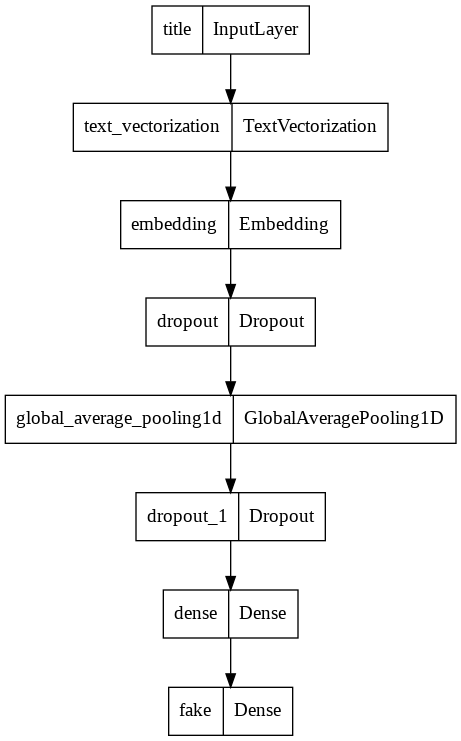

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
#fitting data
history = model.fit(train,
                    validation_data=val,
                    epochs = 50,
                    verbose = False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


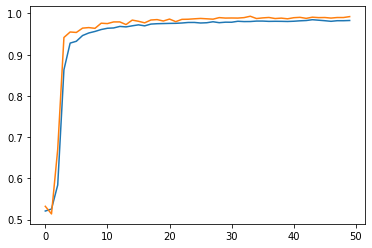

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label="training data")
plt.plot(history.history["val_accuracy"], label="validation data")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

## Model 2: text only

In [ ]:
text_input = keras.Input(
    shape=(1,),
    name = "text", # same name as the dictionary key in the dataset
    dtype = "string"
)

In [ ]:
text_features = text_vectorize_layer(text_input) # apply this "function TextVectorization layer" to lyrics_input
text_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

In [ ]:
output1 = layers.Dense(2, name="fake")(text_features)

In [ ]:
modelText = keras.Model(
    inputs = [text_input],
    outputs = output1
)

In [ ]:
modelText.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
history = modelText.fit(train,
                    validation_data=val,
                    epochs = 50)
                    #verbose = False)

Epoch 1/50
157/157 [==============================] - 6s 40ms/step - loss: 0.0644 - accuracy: 0.9799 - val_loss: 0.0470 - val_accuracy: 0.9876
Epoch 2/50
157/157 [==============================] - 5s 31ms/step - loss: 0.0615 - accuracy: 0.9791 - val_loss: 0.0432 - val_accuracy: 0.9878
Epoch 3/50
157/157 [==============================] - 3s 18ms/step - loss: 0.0608 - accuracy: 0.9799 - val_loss: 0.0389 - val_accuracy: 0.9887
Epoch 4/50
157/157 [==============================] - 3s 18ms/step - loss: 0.0533 - accuracy: 0.9814 - val_loss: 0.0391 - val_accuracy: 0.9916
Epoch 5/50
157/157 [==============================] - 3s 18ms/step - loss: 0.0594 - accuracy: 0.9793 - val_loss: 0.0398 - val_accuracy: 0.9897
Epoch 6/50
157/157 [==============================] - 3s 17ms/step - loss: 0.0570 - accuracy: 0.9807 - val_loss: 0.0378 - val_accuracy: 0.9893
Epoch 7/50
157/157 [==============================] - 3s 17ms/step - loss: 0.0538 - accuracy: 0.9811 - val_loss: 0.0352 - val_accuracy: 0.9911

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [ ]:
#Delete this block of code?

text_features = title_vectorize_layer(text_input) # apply this "function TextVectorization layer" to lyrics_input
text_features = layers.Dense(32, activation='relu')(text_features)

# Model 3: Title and Text

In [ ]:
main = layers.concatenate([title_features, text_features], axis = 1)

In [ ]:
main = layers.Dense(32, activation='relu')(main)
output2 = layers.Dense(2, name="fake")(main)

In [ ]:
modelTextTitle = keras.Model(
    inputs = [title_input, text_input],
    outputs = output2
)

In [ ]:
modelTextTitle.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
history = modelTextTitle.fit(train,
                    validation_data=val,
                    epochs = 20)

Epoch 1/20
157/157 [==============================] - 5s 34ms/step - loss: 0.5939 - accuracy: 0.8006 - val_loss: 0.3341 - val_accuracy: 0.8907
Epoch 2/20
157/157 [==============================] - 4s 27ms/step - loss: 0.4055 - accuracy: 0.8553 - val_loss: 0.2061 - val_accuracy: 0.9567
Epoch 3/20
157/157 [==============================] - 3s 20ms/step - loss: 0.2150 - accuracy: 0.9329 - val_loss: 0.1465 - val_accuracy: 0.9562
Epoch 4/20
157/157 [==============================] - 3s 18ms/step - loss: 0.1749 - accuracy: 0.9475 - val_loss: 0.1264 - val_accuracy: 0.9758
Epoch 5/20
157/157 [==============================] - 3s 18ms/step - loss: 0.1673 - accuracy: 0.9424 - val_loss: 0.0971 - val_accuracy: 0.9829
Epoch 6/20
157/157 [==============================] - 3s 17ms/step - loss: 0.1274 - accuracy: 0.9609 - val_loss: 0.0851 - val_accuracy: 0.9858
Epoch 7/20
157/157 [==============================] - 3s 17ms/step - loss: 0.1117 - accuracy: 0.9647 - val_loss: 0.0741 - val_accuracy: 0.9816

## Model Evaluation on Test Data

In [ ]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
testData = pd.read_csv(test_url)

In [ ]:
testData
testData1 = make_dataset(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
model.evaluate(testData1)

225/225 [==============================] - 1s 4ms/step - loss: 0.0488 - accuracy: 0.9833


[0.04875486344099045, 0.9833400249481201]

## Embedding visualization

In [ ]:
weights = model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = title_vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [ ]:
import plotly.express as px
fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = [2]*len(embedding_df),
                # size_max = 2,
                 hover_name = "word")

fig.show()